# CTM MILP Model Running Environment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *
from ctmmodels.delaythroughput import DelayThroughputSimplex as ConflictModel
from ctmmodels.ringbarrier import DTSimplexRingBarrier as RBModel
from ctmmodels.parentmodel import ParentModel as OldModel

In [3]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'dataframes/'

**Notes on the models and parameters being used:**

* 2 separate formulations were made: 1 dealing with individual movements in the intersection, and another dealing with phases in the stoplight. The latter has 33% less binary variables, and thus performed better in basic tests.

* Saturation flow rate will be set to 600 vph instead of the 450 vph in the parent paper; this is so as to test both under and over saturated conditions.

* Traffic will be distributed evenly between the 3 possible turns (left, through, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step. Preliminary experiments show that 50 is the optimal cycle time for both delay and throughput (at demands ranging from 450 to 900 vph). *However*, previous tests on this model showed that no time was allotted to left turns when the cycle time was too small.

In [4]:
time_range = 30 # time steps
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 1.0/3.0,
    'r_through': 1.0/3.0,
    'r_right': 1.0/3.0,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20
}

# Varying parameters: demand, use_flow_weight, flow_weight, alpha

In [15]:
def run_model(demand, alpha=1, beta=0, gamma=0, log_output=True, preload=None):
    model = OldModel(
        demand=demand,
        preload=preload,
        **parameters
    )
    model.generate()
    runtime = model.solve(log_output=log_output)
    dfx, dfy, dfg = model.return_solution()
    dfparams = model.return_parameters()
    obj_values = model.return_objective_value()
    return dfx, dfy, dfg, dfparams, obj_values, runtime

## Intersection Cell Network

![title](img/4leg-intersection.png)

## Setting the path of cells to check

In [6]:
_approach = 0

_approach_terms = [
    'Left',
    'Through',
    'Right'
]

_cell_path = [
    (CELL_SOURCE,0,_approach),
    (CELL_NORMAL,0,_approach),
    (CELL_NORMAL,1,_approach),
    (CELL_NORMAL,2,_approach),
    (CELL_MOVEMENT,THROUGH_TURN,_approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,_approach))[0]
]

def movement_paths(approach):
    return [
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,LEFT_TURN,approach),
            S_mapping((CELL_MOVEMENT,LEFT_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,THROUGH_TURN,approach),
            S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,RIGHT_TURN,approach),
            S_mapping((CELL_MOVEMENT,RIGHT_TURN,approach))[0]
        ]
    ]

## Comparing cell volumes

In [7]:
def plot_volume(dfx, cell_path, title, headless=True, filename='volume.png'):
    dfx_approach = pd.concat([
        dfx[dfx.cell == c].sort_values(by='timestep')
        for c in cell_path
    ]).pivot(index='timestep', columns='cell', values='volume')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    
    sns.lineplot(data=dfx_approach, ax=axs[0])
    sns.lineplot(data=dfx_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Volume of cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous volume')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Volume of cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative volume')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing flows

In [8]:
def plot_flow(dfy, cell_path, title, headless=True, filename='flow.png'):
    dfy_approach = pd.concat([
        dfy[dfy.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
        for c in cell_path
    ]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))

    sns.lineplot(data=dfy_approach, ax=axs[0])
    sns.lineplot(data=dfy_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Flow from cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous flow')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Flow from cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative flow')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing specific green time

In [21]:
all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

def plot_greentime(dfg, title, headless=True, filename='greentime.png'):
    dfg_map = dfg.pivot(index='timestep', columns='cell', values='is_green')

    fig, axs = plt.subplots(8,1,figsize=(18,18), sharey=True)

    for ndx, t in enumerate(all_phases):
        sns.lineplot(data=dfg_map[t], ax=axs[ndx])
        axs[ndx].text(0.01,.5,all_phases_labels[ndx],
            horizontalalignment='left',
            transform=axs[ndx].transAxes,
            fontsize='large')
        axs[ndx].set_xticks(time_ticks, minor=False)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)


def plot_greentime_map(dfg, title, headless=True, filename='greentime.png'):
    dfg_matrix = dfg.pivot(index='cell', columns='timestep', values='is_green')

    fig, axs = plt.subplots(figsize=(18,9))

    sns.heatmap(data=dfg_matrix)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Generating graphs for each model case

In [10]:
def generate_graphs(dfx, dfy, dfg, capacity, max_flow, demand, alpha, flow_weight, folder=''):
    cell_paths = movement_paths(_approach)
    
    for ndx, cellpath in enumerate(cell_paths):
        if dfx is not None:
            plot_volume(dfx,
                        cellpath,
                        '''Volume in cells at {} vph and {}% delay weight ({} turn)
                        (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                            .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                        filename=folder+'volumes/{}vph_{}alpha_{}flow_volume_{}.png'
                            .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
        
        if dfy is not None:
            plot_flow(dfy,
                      cellpath,
                      '''Flow from cells at {} vph and {}% delay weight ({} turn)
                      (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                          .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                      filename=folder+'flows/{}vph_{}alpha_{}flow_flow_{}.png'
                          .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
    
    if dfg is not None:
        plot_greentime(dfg,
                       '''Green times at {} vph and {}% delay weight
                       (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                           .format(demand, alpha*100, capacity, max_flow, flow_weight),
                       filename=folder+'greentimes/{}vph_{}alpha_{}flow_greetime.png'
                           .format(demand, alpha, flow_weight))

In [11]:
def plot_obj_values(obj_values, title, xaxis, xlabel, headless=True, filename='obj.png'):
    fig, axs = plt.subplots(1,2,figsize=(20,10))

    axs[0].plot(xaxis, [x[0] for x in obj_values])
    axs[0].set_title("Computed total delay")
    axs[0].set_ylabel("Total vehicle delay (timesteps)")
    axs[0].set_xlabel(xlabel)

    axs[1].plot(xaxis, [x[1] for x in obj_values])
    axs[1].set_title("Computed total throughput")
    axs[1].set_ylabel("Total vehicle throughput (veh)")
    axs[1].set_xlabel(xlabel)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Saving dataframes

In [12]:
def save_df(df, filename):
    df.to_pickle(DF_PATH + filename + ".pkl")

## 1. Comparing Conflict and RB models

In [13]:
ctm = {
    (3, 0, 1): 0,
    (3, 1, 1): 0,
    (3, 2, 1): 1,
    (2, 0, 1): 1,
    (2, 1, 1): 1,
    (2, 2, 1): 0,
    (1, 0, 1): 0,

    (3, 0, 0): 11,
    (3, 1, 0): 11,
    (3, 2, 0): 12,
    (2, 0, 0): 4,
    (2, 1, 0): 3,
    (2, 2, 0): 4,
    (1, 0, 0): 0,

    (3, 0, 3): 0,
    (3, 1, 3): 0,
    (3, 2, 3): 1,
    (2, 0, 3): 1,
    (2, 1, 3): 0,
    (2, 2, 3): 1,
    (1, 0, 3): 0,

    (3, 0, 2): 11,
    (3, 1, 2): 11,
    (3, 2, 2): 12,
    (2, 0, 2): 3,
    (2, 1, 2): 6,
    (2, 2, 2): 3,
    (1, 0, 2): 0,
}

In [16]:
dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=600, alpha=0.4, beta=0.4, gamma=0.2, log_output=True, preload=None)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 2816 rows and 380 columns.
MIP Presolve modified 524 coefficients.
Aggregator did 554 substitutions.
Reduced MIP has 3500 rows, 1886 columns, and 11728 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.97 ticks)
Found incumbent of value 0.000000 after 0.03 sec. (23.20 ticks)
Probing time = 0.00 sec. (0.65 ticks)
Tried aggregator 1 time.
Reduced MIP has 3500 rows, 1886 columns, and 11728 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.12 ticks)
Probing time = 0.00 sec. (0.68 ticks)
Clique table members: 1020.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.21 sec. (222.04 ticks)

        Nodes                                         Cuts/
 

  20815  7076      101.0178    92       98.6948      102.2545  1811824    3.61%
  21363  7186      100.5568    69       98.6948      102.2136  1842373    3.57%
  21949  7341       99.2964    47       98.6948      102.1348  1884445    3.49%
Elapsed time = 85.38 sec. (57946.79 ticks, tree = 151.87 MB, solutions = 16)
  22556  7432      100.4611   106       98.6948      102.0859  1924851    3.44%
  23189  7573       99.3466    84       98.6948      102.0298  1973457    3.38%
  23783  7635        cutoff             98.6948      101.9810  2001310    3.33%
  24299  7802       99.9068    90       98.6948      101.9143  2083467    3.26%
  24886  7865        cutoff             98.6948      101.8406  2126889    3.19%
  25540  7881       99.2916    34       98.6948      101.7790  2131911    3.12%
  26203  7966        cutoff             98.6948      101.7145  2182402    3.06%
  26826  8044        cutoff             98.6948      101.6786  2222693    3.02%
  27419  8155      100.2493    64       98.

In [17]:
#print(c_obj_values)
print(obj_values)

99.0281293952


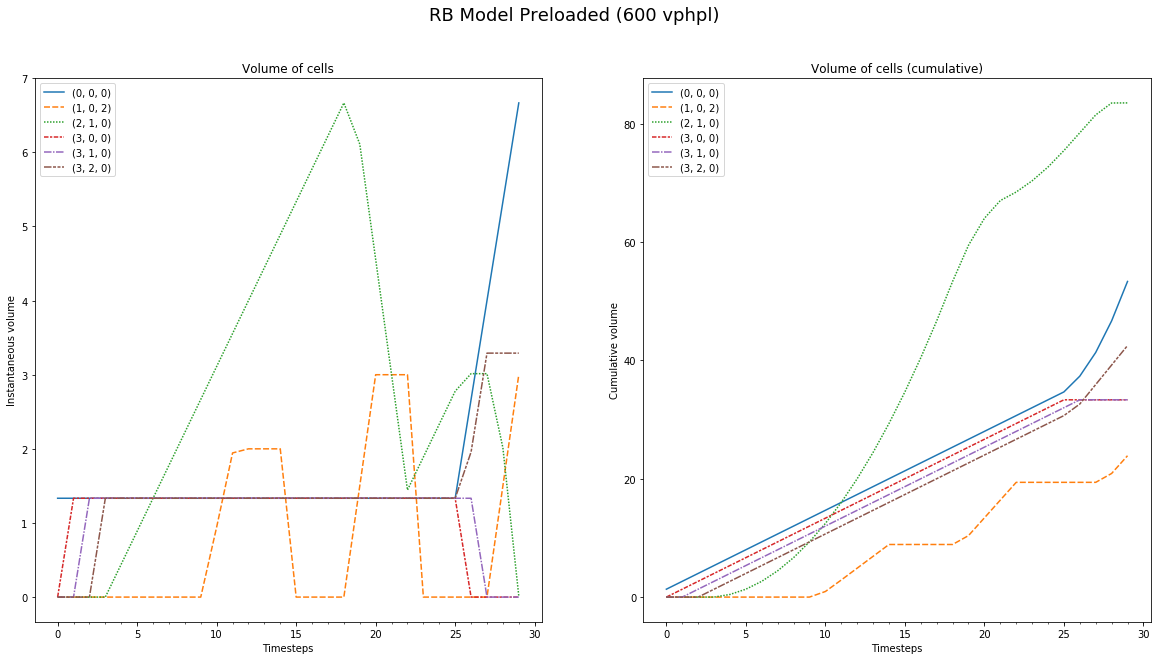

In [18]:
plot_volume(dfx, _cell_path, "RB Model Preloaded (600 vphpl)", headless=False, filename='flow.png')

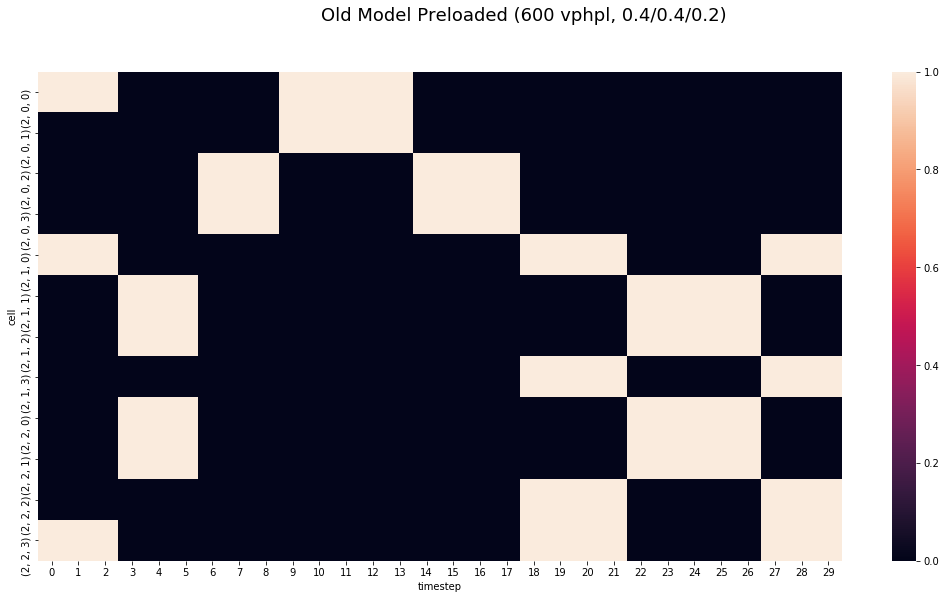

In [23]:
plot_greentime_map(dfg, "Old Model Preloaded (600 vphpl, 0.4/0.4/0.2)", headless=False)

In [24]:
dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=600, alpha=0.4, beta=0.4, gamma=0.2, log_output=True, preload=ctm)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 3 times.
MIP Presolve eliminated 2490 rows and 206 columns.
MIP Presolve modified 549 coefficients.
Aggregator did 574 substitutions.
Reduced MIP has 3806 rows, 2040 columns, and 12495 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (14.22 ticks)
Found incumbent of value 37.181435 after 0.04 sec. (30.46 ticks)
Probing time = 0.00 sec. (0.70 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 3 rows and 3 columns.
Reduced MIP has 3803 rows, 2037 columns, and 12480 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.84 ticks)
Probing time = 0.01 sec. (0.75 ticks)
Clique table members: 1020.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.35 sec. (407.22 ticks)

        Nodes 

                          ------------
Total (root+branch&cut) =   99.60 sec. (59910.61 ticks)
Done!
Time elapsed: 99.6451070309


In [25]:
#print(c_obj_values)
print(obj_values)

124.639240506


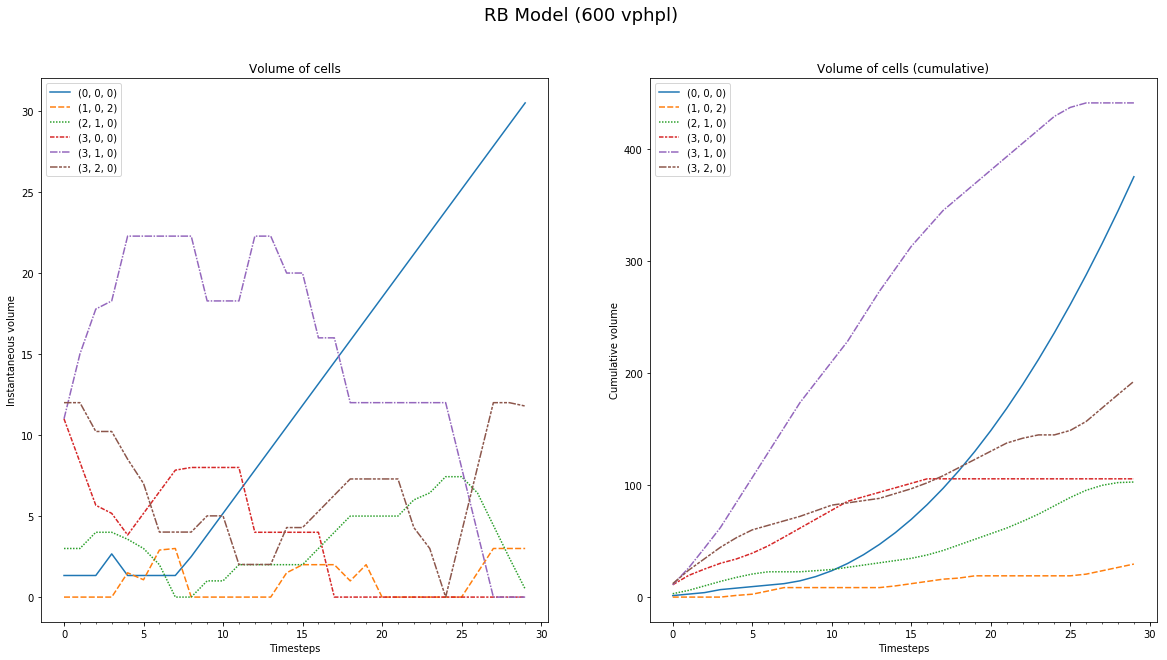

In [26]:
plot_volume(dfx, _cell_path, "RB Model (600 vphpl)", headless=False, filename='flow.png')

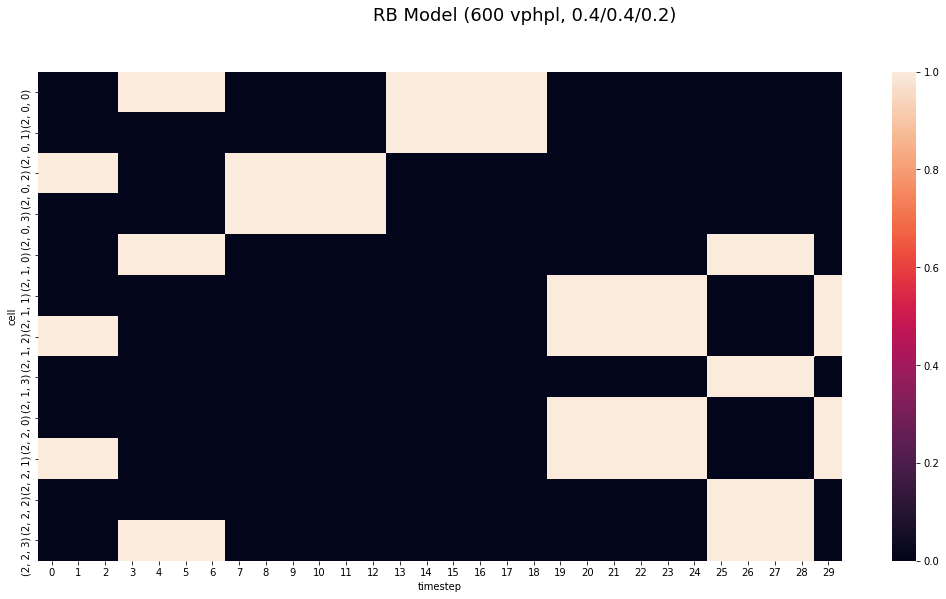

In [27]:
plot_greentime_map(dfg, "RB Model (600 vphpl, 0.4/0.4/0.2)", headless=False)